In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Image Proprocessing

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

image_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    channel_shift_range=50,
    preprocessing_function=orthogonal_rot
)

In [3]:
train_dir = "/content/drive/My Drive/pneumonia/train"
val_dir = "/content/drive/My Drive/pneumonia/val"
test_dir="/content/drive/My Drive/pneumonia/test"

# Define the batch size and image size
batch_size = 32
image_size = (180, 180)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=image_size)

validation = ImageDataGenerator().flow_from_directory(val_dir, 
                                                batch_size=batch_size, 
                                                shuffle=False, 
                                                class_mode='categorical',
                                                target_size=image_size)

test_generator = ImageDataGenerator().flow_from_directory(test_dir,
                                                          target_size=image_size,
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
)

Found 3504 images belonging to 3 classes.
Found 1169 images belonging to 3 classes.
Found 1169 images belonging to 3 classes.


# VGG16 
## https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning#VGG16 

In [4]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [5]:
def build_model(batch_size=32, dropout_rate=0.2):
    # Define the base VGG16 model and freeze its layers
    vgg16_base_model = VGG16(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

    for layer in vgg16_base_model.layers[:-2]:
        layer.trainable = False
    
    # Define the architecture of the dynamic model
    vgg16_dynamic = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(3, activation="softmax")
    ])
    
    # Define the learning rate schedule using ExponentialDecay
    initial_learning_rate = 0.1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.97,
        staircase=True
    )
    
    # Compile the model with the desired optimizer, loss function, and metrics
    vgg16_dynamic.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    
    return vgg16_dynamic

In [6]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Create the KerasClassifier wrapper for scikit-learn compatibility
keras_classifier = KerasClassifier(build_fn=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3)

# Get the X and y from the train and validation data generators
train_X, train_y = next(train)
val_X, val_y = next(validation)

# Fit the GridSearchCV with the generator-based training dataset
grid_search.fit(train_X, train_y, epochs=10, validation_data=(val_X, val_y), verbose=1)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Create the final model with the best hyperparameters
best_model = build_model(batch_size=32, dropout_rate=best_params['dropout_rate'])

<ipython-input-6-64d89186a4cf>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=build_model, verbose=0)


Epoch 1/10
1/1 [==============================] - 20s 20s/step - loss: 1.4592 - accuracy: 0.4762 - precision: 0.4500 - recall: 0.4286 - val_loss: 292369.9375 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 193ms/step - loss: 2.5560 - accuracy: 0.4286 - precision: 0.4286 - recall: 0.4286 - val_loss: 19912.3203 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 192ms/step - loss: 1.6230 - accuracy: 0.7143 - precision: 0.6842 - recall: 0.6190 - val_loss: 26819.0938 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 195ms/step - loss: 0.3674 - accuracy: 0.8571 - precision: 0.8571 - recall: 0.8571 - val_loss: 12938.9932 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
1/1 [==============================] 

In [9]:
# Fit the final model with the training dataset
history=best_model.fit(train, epochs=16, validation_data=validation)

test_results = best_model.evaluate(test_generator)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)

Epoch 1/16
110/110 [==============================] - 1927s 18s/step - loss: 0.9243 - accuracy: 0.5736 - precision: 0.6175 - recall: 0.4943 - val_loss: 0.6572 - val_accuracy: 0.7066 - val_precision: 0.7415 - val_recall: 0.6527
Epoch 2/16
110/110 [==============================] - 91s 828ms/step - loss: 0.7279 - accuracy: 0.6692 - precision: 0.7134 - recall: 0.6096 - val_loss: 1.1879 - val_accuracy: 0.6065 - val_precision: 0.6111 - val_recall: 0.5928
Epoch 3/16
110/110 [==============================] - 89s 807ms/step - loss: 0.6991 - accuracy: 0.6747 - precision: 0.7161 - recall: 0.6199 - val_loss: 0.9398 - val_accuracy: 0.5620 - val_precision: 0.6391 - val_recall: 0.5364
Epoch 4/16
110/110 [==============================] - 94s 860ms/step - loss: 0.6889 - accuracy: 0.6804 - precision: 0.7173 - recall: 0.6270 - val_loss: 0.8613 - val_accuracy: 0.6980 - val_precision: 0.7086 - val_recall: 0.6843
Epoch 5/16
110/110 [==============================] - 89s 807ms/step - loss: 0.6835 - accura

In [ ]:
best_model.save('/content/drive/My Drive/pneumonia/vgg_tuned.h5')

Text(0.5, 1.0, 'Accuracy Evolution')

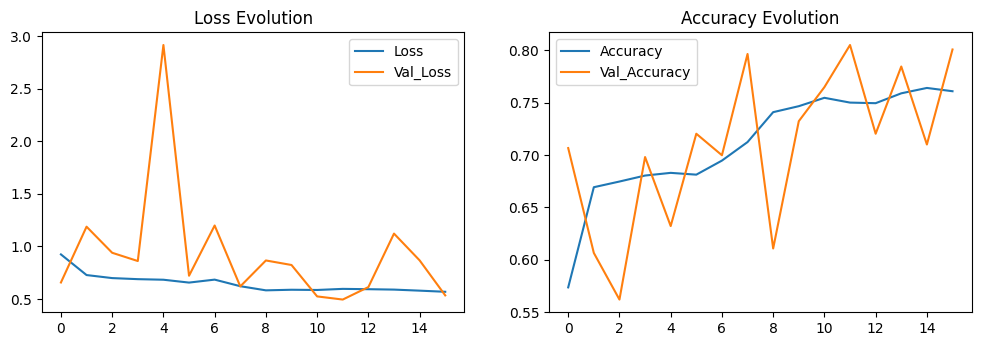

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

37/37 [==============================] - 16s 432ms/step


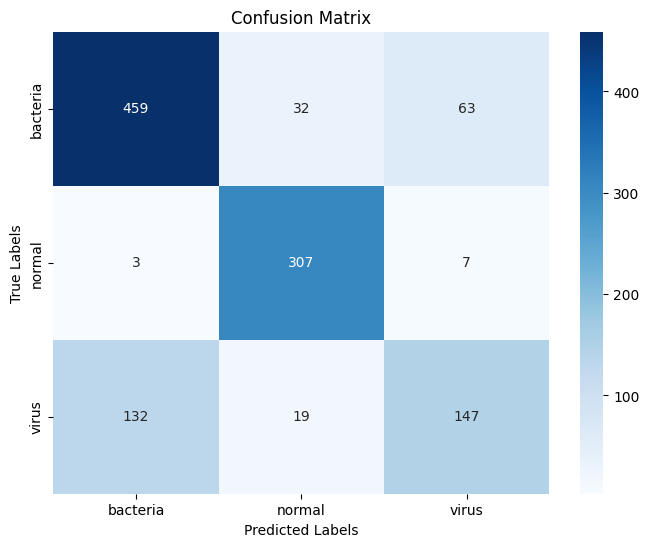

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import seaborn as sns
import numpy as np

# Generate predictions for the test set
y_pred = best_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtain true labels for the test set
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

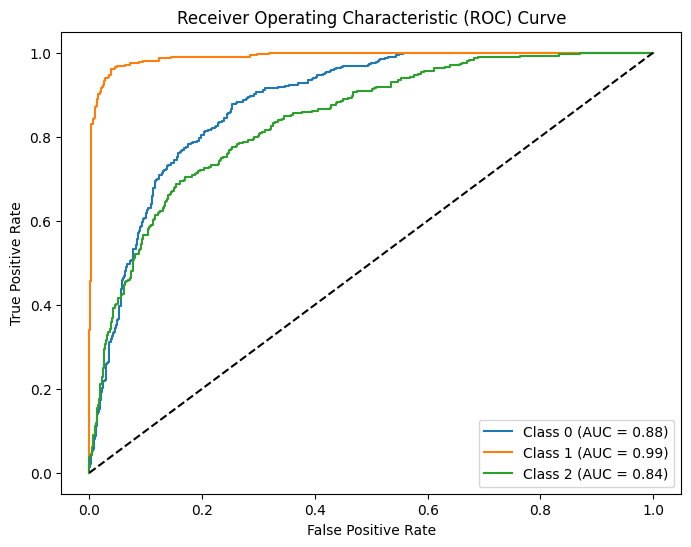

In [12]:
# Generate ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_label in range(len(test_generator.class_indices)):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_true == class_label, y_pred[:, class_label])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for class_label in range(len(test_generator.class_indices)):
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

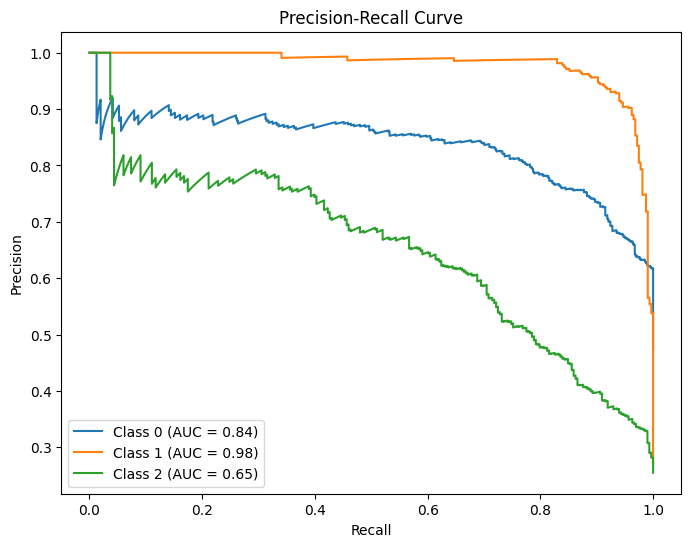

In [13]:
# Generate precision-recall curve
precision = dict()
recall = dict()
pr_auc = dict()
for class_label in range(len(test_generator.class_indices)):
    precision[class_label], recall[class_label], _ = precision_recall_curve(y_true == class_label, y_pred[:, class_label])
    pr_auc[class_label] = auc(recall[class_label], precision[class_label])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
for class_label in range(len(test_generator.class_indices)):
    plt.plot(recall[class_label], precision[class_label], label=f"Class {class_label} (AUC = {pr_auc[class_label]:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()